<a href="https://colab.research.google.com/github/briannabinder/AME508_finalproject/blob/main/112723AME508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsampler import ImbalancedDatasetSampler


: 

Drive mount from my personal driver

In [21]:
#from google.colab import drive
#drive.mount('/content/drive')

Wav to spectrogram

nperseg: 448 noverlap: 181
File: 4666.wav, Spectrogram shape: (224, 224)


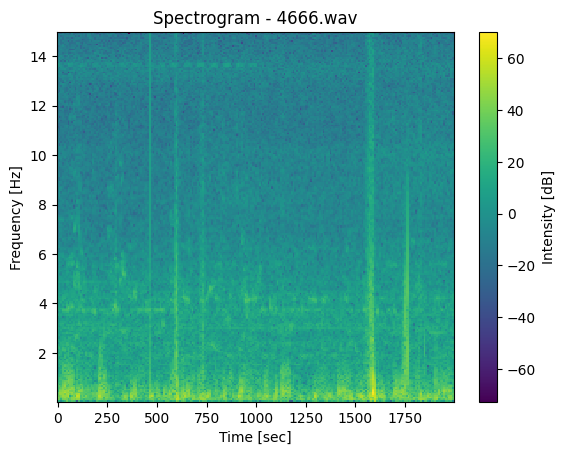

(7809, 1, 224, 224)


In [3]:
# Specify the folder path
#folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Train_Datasets'
# folder_path = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train2'
folder_path = '/Users/briannabinder/Desktop/508/AME508_finalproject/train2'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# List to store all log_spectrograms
all_spectrograms = []

def calculate_noverlap():
  steth_sample_rate = 4000
  duration = 15
  total_samples = steth_sample_rate * duration
  num_freq_bins = 224
  num_time_steps = 224

  nperseg = 2 * num_freq_bins  # (Nyquist limit)

  # num_time_steps = (total samples - noverlap) / (nperseg - noverlap)
  # t = s - o / p - o
  # tp - to = s - o
  # o = (tp - s) / (t - 1)

  noverlap = round((num_time_steps * nperseg - total_samples) / (num_time_steps - 1))
  return int(nperseg), int(noverlap)

nperseg, noverlap = calculate_noverlap()
print("nperseg:", nperseg, "noverlap:", noverlap)

def plot_spectrogram(nperseg, noverlap):
    # Iterate through each .wav file in the folder
    for wav_file in file_list:
        # Construct the full path to the .wav file
        wav_file_path = os.path.join(folder_path, wav_file)

        # Read the WAV file
        sample_rate, samples = wavfile.read(wav_file_path)

        # Compute the spectrogram
        frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

        # Apply logarithmic transformation
        log_spectrogram = resize(10 * np.log10(spectrogram+1e-10),(224,224))

        # Store the log_spectrogram in the list
        all_spectrograms.append(log_spectrogram)

    # Print the shape of the first spectrogram
    print(f"File: {file_list[0]}, Spectrogram shape: {all_spectrograms[0].shape}")

    # Ensure X has shape (225, 224) and Y has shape (224, 225)
    X, Y = np.meshgrid(times[:225], frequencies[:224], indexing='ij')

    #print(f"Original Spectrogram shape: {spectrogram.shape}")
    #print(f"Resized Spectrogram shape: {all_spectrograms[0].shape}")
    #print(f"X shape: {X.shape}")
    #print(f"Y shape: {Y.shape}")
    

    # Plot the first spectrogram
    plt.pcolormesh(Y, X, all_spectrograms[0], shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram - {file_list[0]}')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Plot the spectrogram with calculated nperseg and noverlap
plot_spectrogram(nperseg, noverlap)

all_resized_spectrograms = np.reshape(np.array(all_spectrograms), newshape=(7809,1,224,224))

print(all_resized_spectrograms.shape)

Test datasets .wav

In [ ]:
''' REDOOOOOOOOO



# Specify the folder path
#folder_path1 = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Test_Datasets'
folder_path1 ='/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/test'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if f.endswith('.wav')]

# List to store all log_spectrograms
all_spectrograms1 = []

# Iterate through each .wav file in the folder
for wav_file in file_list:
    # Construct the full path to the .wav file
    wav_file_path = os.path.join(folder_path1, wav_file)

    # Read the content of the .wav file
    sample_rate, samples = wavfile.read(wav_file_path)

    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    # Apply logarithmic transformation
    log_spectrogram1 = 10 * np.log10(spectrogram)

    # Store the log_spectrogram in the list
    all_spectrograms1.append(log_spectrogram1)

# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms1 = []

# Iterate through each log_spectrogram
for log_spectrogram1 in all_spectrograms1:
    # Resize the log_spectrogram to the target size
    resized_log_spectrogram1 = resize(log_spectrogram1, target_size, anti_aliasing=True)

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms1.append(resized_log_spectrogram1)


all_resized_spectrograms1 = np.reshape(np.array(all_resized_spectrograms1), newshape=(1185,1,224,224))


print(all_resized_spectrograms1.shape)
'''


Train datasets Label Reader Mulit Hot Encoder


In [24]:
'''
# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices = np.array([item['vector'] for item in all_multi_hot_matrices])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices)}")
'''


Total count of files: 0


In [8]:
# Get a list of all .npy files in the folder
npy_file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

# List to store file names and arrays
all_multi_hot_matrices = []

# Iterate through each .npy file
for npy_file in npy_file_list:
    # Construct the full path to the .npy file
    npy_file_path = os.path.join(folder_path, npy_file)

    # Load the .npy file
    multi_hot_array = np.load(npy_file_path)

    # Remove the file extension from the file name
    file_name = os.path.splitext(npy_file)[0]

    # Append the file name and array to the list
    all_multi_hot_matrices.append({
        'file_name': file_name,
        'array': multi_hot_array.tolist()  # Convert to list for better readability
    })

# Create a NumPy array to store all the arrays
multi_hot_matrices = np.array([item['array'] for item in all_multi_hot_matrices])

'''
# Print or use the values as needed
for item in all_multi_hot_matrices:
    file_name = item['file_name']
    array = item['array']
    print(f"File: {file_name}, Array: {array}")
'''

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices)}")


Total count of files: 7809


Test_datasets Label Reader Mulit Hot Encoder

In [ ]:
''' REDOOOOOOOOO

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi', 'Crackles']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices1 = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path1, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector1 = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector1.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices1.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector1
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices1 = np.array([item['vector'] for item in all_multi_hot_matrices1])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices1:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices1)}")
'''

CustomDataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label
    
    def get_labels(self):
        """
        Returns the labels of the dataset.
        """
        return self.labels

In [9]:
batch_size = 32
train_dataset = CustomDataset(all_resized_spectrograms,multi_hot_matrices)

# Define a sampler for the training dataset
#train_sampler = ImbalancedDatasetSampler(train_dataset)

#test_dataset = CustomDataset(all_resized_spectrograms1,multi_hot_matrices1)

trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)#, sampler=train_sampler)

#testloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1185)

 VGG16 CNN as feature extractors



In [13]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 3)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        
        
        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

Check for GPU

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


Testing VGG16 CNN shape size

In [15]:
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True)
output = model(torch.ones(size=(1,1,224,224)))
# More infor on VGG16 (https://builtin.com/machine-learning/vgg16)

Intermediate shapes for VGG16
Input shape: torch.Size([1, 1, 224, 224])
After Layer 1: torch.Size([1, 64, 112, 112])
After Layer 2: torch.Size([1, 128, 56, 56])
After Layer 3: torch.Size([1, 256, 28, 28])
After Layer 4: torch.Size([1, 512, 14, 14])
After Layer 5 torch.Size([1, 512, 7, 7])
Flattened: torch.Size([1, 25088])
After first Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
After Secound Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
Output shape: torch.Size([1, 3])


In [ ]:
#torch.cuda.empty_cache()

#torch.cuda.memory_summary(device=None, abbreviated=False)

Training VGG16 CNN with BCE Loss

In [ ]:
def check_nonzero(y_true, y_pred):
    for sample in y_true:
        if any(value != 0 for value in sample):
            return True
    for sample in y_pred:
        if any(value != 0 for value in sample):
            return True
    return False
        

def train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every):
    loss_hist = np.zeros(n_epoch * n_batches)
    precision_hist = np.zeros((n_epoch, 3))
    recall_hist = np.zeros((n_epoch, 3))
    f1_hist = np.zeros((n_epoch, 3))
    
    avg_precision_epoch = np.zeros((n_epoch, 3))
    avg_recall_epoch = np.zeros((n_epoch, 3))
    avg_f1_epoch = np.zeros((n_epoch, 3))

    it = 0
    for epoch in range(n_epoch):
        all_predictions = []
        all_labels = []
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # Convert logits to binary predictions
            predictions = (outputs > 0.5).float()

            # Aggregate predictions and labels for the entire epoch
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loss_hist[it] = loss.item()

            it += 1

            if (i + 1) % print_every == 0:
                print('minibatch = {}/{}, loss = {}'.format(i + 1, n_batches, loss.item()))

        # Calculate precision, recall, and F1 for the entire epoch
        if (check_nonzero(all_labels, all_predictions)):
            precision = precision_score(all_labels, all_predictions, average=None)
        else:
            precision = 0

        precision_hist[epoch] = precision
        recall = recall_score(all_labels, all_predictions, average=None)
        f1 = f1_score(all_labels, all_predictions, average=None)

        recall_hist[epoch] = recall
        f1_hist[epoch] = f1

        # Calculate and print average precision, recall, and F1 for the epoch
        avg_precision_epoch[epoch] = np.mean(precision)
        avg_recall_epoch[epoch] = np.mean(recall)
        avg_f1_epoch[epoch] = np.mean(f1)

        print('epoch = {}/{}, Avg Precision = {}, Avg Recall = {}, Avg F1 score = {}'.format(epoch + 1, n_epoch,
                                                                                              avg_precision_epoch[epoch],
                                                                                              avg_recall_epoch[epoch],
                                                                                              avg_f1_epoch[epoch]))

    print("Finished Training")
    return loss_hist, precision_hist, recall_hist, f1_hist, avg_precision_epoch, avg_recall_epoch, avg_f1_epoch



Running train loop with BCE loss

What could work:
- Find number of each class present
- convert into one hot encoded into multi hot encoded and make BCE work
- Then check precision, recall stuff
- Make everythig including testing works with one hot encoded
- make sure test dataset also has same class imabalance
- if everything works and there is time, convert to multi-hot encoded


In [25]:
'''
# Calculate class frequencies
class_counts = np.sum(multi_hot_matrices, axis=0)

# Add a small constant to avoid division by zero
epsilon = 1e-10
class_weights = 1.0 / (class_counts + epsilon)

# Normalize class weights
class_weights /= np.sum(class_weights)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.Tensor(class_weights)

'''
model = VGG16()#.to(device)
criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights_tensor)
learning_rate = 0.01 
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-8)
n_epoch   = 10
n_batches = len(trainloader)
print_every = 1

loss_bce, precision_bce, recall_bce, f1_bce = train_loop_bce(model,criterion,optimizer,n_epoch,n_batches,print_every)

minibatch = 1/245, loss = 0.6957444548606873
minibatch = 2/245, loss = 2800442146816.0
minibatch = 3/245, loss = 5256.53173828125
minibatch = 4/245, loss = 5490896.5
minibatch = 5/245, loss = 13545771.0
minibatch = 6/245, loss = 271303968.0
minibatch = 7/245, loss = 47948845056.0
minibatch = 8/245, loss = 378961760.0
minibatch = 9/245, loss = 1944237.125
minibatch = 10/245, loss = 592857.1875
minibatch = 11/245, loss = 646704.625
minibatch = 12/245, loss = 35367.78515625
minibatch = 13/245, loss = 179006.296875
minibatch = 14/245, loss = 466482.28125
minibatch = 15/245, loss = 105132.8359375
minibatch = 16/245, loss = 70213.65625
minibatch = 17/245, loss = 1151098.625
minibatch = 18/245, loss = 421295.84375
minibatch = 19/245, loss = 234061.890625
minibatch = 20/245, loss = 163768.5
minibatch = 21/245, loss = 6583839.5
minibatch = 22/245, loss = 32013934.0
minibatch = 23/245, loss = 2109628.75
minibatch = 24/245, loss = 195767.453125
minibatch = 25/245, loss = 828463.5
minibatch = 26/2

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.4627448320388794
minibatch = 2/245, loss = 0.3512420356273651
minibatch = 3/245, loss = 0.4056466519832611
minibatch = 4/245, loss = 0.4344884157180786
minibatch = 5/245, loss = 0.4509839713573456
minibatch = 6/245, loss = 0.3459116220474243
minibatch = 7/245, loss = 0.33686283230781555
minibatch = 8/245, loss = 0.43263134360313416
minibatch = 9/245, loss = 0.30487915873527527
minibatch = 10/245, loss = 0.41376757621765137
minibatch = 11/245, loss = 0.4129283130168915
minibatch = 12/245, loss = 0.4790710508823395
minibatch = 13/245, loss = 0.2974291145801544
minibatch = 14/245, loss = 0.4442024230957031
minibatch = 15/245, loss = 0.3792017996311188
minibatch = 16/245, loss = 0.36409714818000793
minibatch = 17/245, loss = 0.36467576026916504
minibatch = 18/245, loss = 0.3529689610004425
minibatch = 19/245, loss = 0.4203299582004547
minibatch = 20/245, loss = 0.34451696276664734
minibatch = 21/245, loss = 0.3596355617046356
minibatch = 22/245, loss = 0.3218791

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.3903050720691681
minibatch = 2/245, loss = 0.26565438508987427
minibatch = 3/245, loss = 0.3882500231266022
minibatch = 4/245, loss = 0.3312723934650421
minibatch = 5/245, loss = 0.36805567145347595
minibatch = 6/245, loss = 0.4273894727230072
minibatch = 7/245, loss = 0.3226947486400604
minibatch = 8/245, loss = 0.3979862630367279
minibatch = 9/245, loss = 0.43927621841430664
minibatch = 10/245, loss = 0.3254402279853821
minibatch = 11/245, loss = 0.3327823877334595
minibatch = 12/245, loss = 0.4067852795124054
minibatch = 13/245, loss = 0.2923974096775055
minibatch = 14/245, loss = 0.485500693321228
minibatch = 15/245, loss = 0.4105954170227051
minibatch = 16/245, loss = 0.4272870719432831
minibatch = 17/245, loss = 0.2899075448513031
minibatch = 18/245, loss = 0.27566343545913696
minibatch = 19/245, loss = 0.4070148766040802
minibatch = 20/245, loss = 0.3958824574947357
minibatch = 21/245, loss = 0.3447194993495941
minibatch = 22/245, loss = 0.37354198098

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.34219440817832947
minibatch = 2/245, loss = 0.39634251594543457
minibatch = 3/245, loss = 0.4220283329486847
minibatch = 4/245, loss = 0.3962205648422241
minibatch = 5/245, loss = 0.43607330322265625
minibatch = 6/245, loss = 0.37703168392181396
minibatch = 7/245, loss = 0.38065049052238464
minibatch = 8/245, loss = 0.43321871757507324
minibatch = 9/245, loss = 0.36060038208961487
minibatch = 10/245, loss = 0.3216487765312195
minibatch = 11/245, loss = 0.3186678886413574
minibatch = 12/245, loss = 0.43666648864746094
minibatch = 13/245, loss = 0.39533793926239014
minibatch = 14/245, loss = 0.34168997406959534
minibatch = 15/245, loss = 0.35363543033599854
minibatch = 16/245, loss = 0.48212751746177673
minibatch = 17/245, loss = 0.3944329023361206
minibatch = 18/245, loss = 0.30834969878196716
minibatch = 19/245, loss = 0.36588791012763977
minibatch = 20/245, loss = 0.40753641724586487
minibatch = 21/245, loss = 0.42358437180519104
minibatch = 22/245, loss = 

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.4436599016189575
minibatch = 2/245, loss = 0.33075690269470215
minibatch = 3/245, loss = 0.44916078448295593
minibatch = 4/245, loss = 0.4270012378692627
minibatch = 5/245, loss = 0.41491949558258057
minibatch = 6/245, loss = 0.30587974190711975
minibatch = 7/245, loss = 0.47100770473480225
minibatch = 8/245, loss = 0.5356139540672302
minibatch = 9/245, loss = 0.41389092803001404
minibatch = 10/245, loss = 0.46240904927253723
minibatch = 11/245, loss = 0.4060100317001343
minibatch = 12/245, loss = 0.32456809282302856
minibatch = 13/245, loss = 0.38236379623413086
minibatch = 14/245, loss = 0.35187777876853943
minibatch = 15/245, loss = 0.3702077865600586
minibatch = 16/245, loss = 0.4039151668548584
minibatch = 17/245, loss = 0.33771273493766785
minibatch = 18/245, loss = 0.322282999753952
minibatch = 19/245, loss = 0.3949767053127289
minibatch = 20/245, loss = 0.3092047870159149
minibatch = 21/245, loss = 0.3068225681781769
minibatch = 22/245, loss = 0.3771

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.39096012711524963
minibatch = 2/245, loss = 0.33303502202033997
minibatch = 3/245, loss = 0.37380194664001465
minibatch = 4/245, loss = 0.3474064767360687
minibatch = 5/245, loss = 0.26970377564430237
minibatch = 6/245, loss = 0.31262147426605225
minibatch = 7/245, loss = 0.5043293237686157
minibatch = 8/245, loss = 0.4262499511241913
minibatch = 9/245, loss = 0.44168558716773987
minibatch = 10/245, loss = 0.5035871863365173
minibatch = 11/245, loss = 0.44162991642951965
minibatch = 12/245, loss = 0.3773399293422699
minibatch = 13/245, loss = 0.3911060392856598
minibatch = 14/245, loss = 0.3313668966293335
minibatch = 15/245, loss = 0.3554680347442627
minibatch = 16/245, loss = 0.3133286237716675
minibatch = 17/245, loss = 0.3346776068210602
minibatch = 18/245, loss = 0.42982351779937744
minibatch = 19/245, loss = 0.2979373037815094
minibatch = 20/245, loss = 0.5322101712226868
minibatch = 21/245, loss = 0.42680445313453674
minibatch = 22/245, loss = 0.38981

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: too many values to unpack (expected 4)

Plotting BCE training losses

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training loss
axs[0].plot(loss_bce, label="Train Datasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(precision_bce, label="Precision", color='blue')
axs[1].set_ylabel('Metric')

# Add two more curves for accuracy
axs[1].plot(recall_bce, label="Recall", color='green')
axs[1].plot(f1_bce, label="F1 Score", color='red')

axs[1].set_xlabel('Iterations')
axs[1].legend()

plt.show()

Class for sensitivity-specificity loss (SS loss)

In [ ]:
class SensitivitySpecificityLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(SensitivitySpecificityLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, outputs, targets):
        # Convert multi-hot encoded targets to binary
        targets_binary = (targets > 0.5).float()

        # Calculate true positive, true negative, false positive, and false negative
        true_positive = torch.sum((outputs > 0.5) * (targets_binary == 1)).float()
        true_negative = torch.sum((outputs <= 0.5) * (targets_binary == 0)).float()
        false_positive = torch.sum((outputs > 0.5) * (targets_binary == 0)).float()
        false_negative = torch.sum((outputs <= 0.5) * (targets_binary == 1)).float()

        # Calculate sensitivity and specificity
        sensitivity = true_positive / (true_positive + false_negative + 1e-10)
        specificity = true_negative / (true_negative + false_positive + 1e-10)

        # Use sensitivity and specificity in the loss function
        loss = self.alpha * (1 - sensitivity) + self.beta * (1 - specificity)

        return torch.tensor(loss, requires_grad=True)


Train loop with SS loss

In [ ]:
def train_loop_ss(model,criterion,optimizer,n_epoch,n_batches,print_every):
    loss_hist = np.zeros(n_epoch*n_batches)
    acc_hist  = np.zeros(n_epoch*n_batches)

    it = 0
    for epoch in range(n_epoch):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            loss_hist[it] = loss.item()
            _, predicted = torch.max(outputs.data, 1)
            acc_hist[it] = 100.0 * torch.sum(torch.from_numpy(predicted.cpu().numpy()) == torch.argmax(torch.from_numpy(labels.cpu().numpy()), axis=1)).item() / labels.size(0)



            if (i + 1) % print_every == 0:
                print('epoch = {}/{}, minibatch = {}/{}, loss = {}, accuracy = {}'.format(epoch + 1, n_epoch, i + 1,
                                                                                        n_batches, loss.item(),
                                                                                        acc_hist[it]))
        it += 1

    print('Finished Training')
    return loss_hist, acc_hist

Running train loop with SS loss

In [ ]:

model = VGG16().to(device)
criterion = SensitivitySpecificityLoss(alpha=0.5, beta=0.5)  # Adjust alpha and beta as needed
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
n_epoch = 1
n_batches = len(trainloader)
print_every = 10

loss_ss, acc_ss = train_loop_ss(model,criterion,optimizer,n_epoch,n_batches,print_every)

Plot SS loss metric

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_ss, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()


axs[1].plot(acc_ss, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()

Save the variable of training model for reusing purpose

In [ ]:
# Save all relevant information at the end of training
#Store_variable = {
 #   'model_state_dict': model.state_dict(),
 #   'optimizer_state_dict': optimizer.state_dict(),
 #   'loss_history': loss_hist,
 #   'accuracy_history': acc_hist,
 #   'train_dataset' : train_dataset,
 #   'test_dataset' : test_dataset,
 #   'trainloader' : trainloader,
 #   'testloader' : testloader,
#}

# Save the model to a file
torch.save({'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_hist,
    'accuracy_history': acc_hist,
    'train_dataset' : train_dataset,
    'test_dataset' : test_dataset,
    'trainloader' : trainloader,
    'testloader' : testloader}, )
# Create a download link link from Jupyter Notebook
from IPython.display import FileLink
FileLink(Store_variable)

# Load the model from the file
model, optimizer, loss_history, accuracy_history, train_dataset,test_dataset,trainloader,testloader = torch.load(Store_variable).values()

Testing

In [ ]:
# Find accuracy over tasting set

def find_vacc(net,loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += np.sum(predicted.cpu().numpy() == np.argmax(labels.numpy(), axis=1))
    vacc = 100.0 * correct / total
    return vacc

test_acc = find_vacc(model, testloader)

print(f'Accuracy of the network trained on the test images: {test_acc} %')